In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn import cross_validation
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

train = pd.read_csv('data/train.csv', header=0)
test = pd.read_csv('data/test.csv', header=0);

target_var = "Survived"
predictors = ["Pclass", "Sex", "Parch", "Fare", "HasSons", "Embarked", "HasSiblings", "Age", "Title", "IsChild"] #, "SibSp"

In [2]:
import re

# A function to get the title from a name.
def parse_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and 
    #lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

def extract_titles(df):
    # Get all the titles and print how often each one occurs.
    titles = df["Name"].apply(parse_title)
    #print(pd.value_counts(titles))

    # Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, \
                     "Mlle": 8, "Mme": 8, "Don": 9, "Dona": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, \
                     "Capt": 7, "Ms": 2}
    for k,v in title_mapping.items():
        titles[titles == k] = v

    # Verify that we converted everything.
    #print(pd.value_counts(titles))

    # Add in the title column.
    df["Title"] = titles

def get_deck(cabin):
    try:
        return cabin[0]
    except:
        return "Not Reported"
    
def preprocess(df):
    df["Embarked"].fillna("S", inplace=True)
    
    extract_titles(df)
    
    mean_imputer = preprocessing.Imputer(strategy="mean")
    df[["Age", "Fare"]] = mean_imputer.fit_transform(df[["Age", "Fare"]])
    mode_imputer = preprocessing.Imputer(strategy="most_frequent")
    df[["Parch", "SibSp"]] = mode_imputer.fit_transform(df[["Parch", "SibSp"]])
    
    df["HasSons"] = 0
    df.loc[(df["Parch"] > 0) & (df["Age"] < 18), "HasSons"] = 1
    df["HasSiblings"] = 0
    df.loc[df["SibSp"] > 0, "HasSiblings"] = 1
    df["IsChild"] = 0
    df.loc[df["Age"] < 14, "IsChild"] = 1
    
    df["Deck"] = df["Cabin"].apply(get_deck)
    
    categorical_predictors = ["Sex", "Embarked", "Deck"]
    for cat_pred in categorical_predictors:
        encoder = preprocessing.LabelEncoder()
        df[cat_pred] = encoder.fit_transform(df[cat_pred])
    
    df = pd.concat([df, pd.get_dummies(df["Title"], prefix="Title")], axis=1)
    return df
    
train = preprocess(train)
test = preprocess(test)

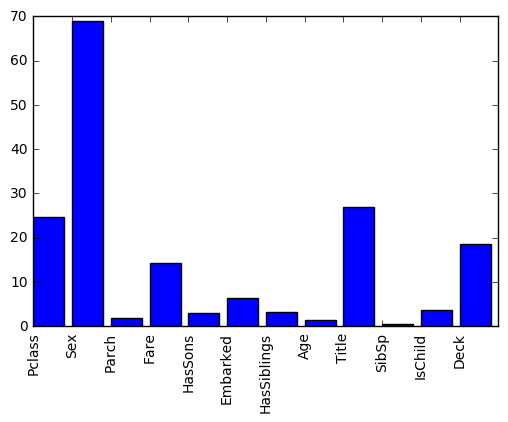

0.820426487093


In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif

predictors = ["Pclass", "Sex", "Parch", "Fare", "HasSons", "Embarked", "HasSiblings", "Age", "Title", "SibSp", "IsChild", "Deck"]

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(train[predictors], train["Survived"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

# Pick only the four best features.
predictors = ["Pclass", "Sex", "Fare", "Title", "Embarked", "IsChild", "HasSiblings"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=8, min_samples_leaf=4)

scores = cross_validation.cross_val_score(alg, train[predictors], train["Survived"])
print(scores.mean())

In [7]:
predictors = ["Pclass", "Sex", "Fare", "HasSons", "Embarked", "HasSiblings", "Title", "IsChild", "Deck"] #, "SibSp", "Age", "Parch", "HasManyChildren

#scaler = StandardScaler()
#train[predictors] = scaler.fit_transform(train[predictors])
epsilon = 0.00001
train[predictors] = (train[predictors] - train[predictors].mean()) / (train[predictors].std() * 2 + epsilon)

algorithms = [
    ['lr', LogisticRegression(), predictors],
    ['gbc', GradientBoostingClassifier(n_estimators=25, max_depth=3), predictors],
    ['abc', AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=25, algorithm="SAMME.R", learning_rate=1.3), predictors],
    ['rfc', RandomForestClassifier(n_estimators=150, min_samples_split=8, min_samples_leaf=4), predictors + ["Parch", "SibSp", "Age"]],
    ['svc gaussian', SVC(kernel="rbf", C=100, gamma=0.05, probability=False),\
         ['Pclass', 'Sex', 'Fare', 'HasSons', 'Embarked', \
          'HasSiblings', 'IsChild', 'Title_1', 'Title_2', \
          'Title_3', 'Title_4', 'Title_5', 'Title_6', 'Title_7', \
          'Title_8', 'Title_9', 'Title_10', "Parch", "SibSp", "Age"]]
]

X_trainG, X_testG, Y_trainG, Y_testG = cross_validation.train_test_split(train[predictors], train[target_var], test_size = 0.30)

predictions = []

models = [(x[0], x[1]) for x in algorithms]
voting_classifier = VotingClassifier(models, voting="hard")
all_models = [x[1] for x in algorithms] + [voting_classifier]

for clf, label in zip(all_models, 
                      ['Logistic Regression', 
                       'Gradient Boosting Classifier', 
                       'AdaBoost Classifier', 
                       'RandomForest', 
                       'Gaussian Support Vector Machine']):
    scores = cross_validation.cross_val_score(clf, X_trainG, Y_trainG, cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

voting_classifier.fit(X_trainG, Y_trainG)
predictions = voting_classifier.predict(X_testG)
print (metrics.accuracy_score(Y_testG, predictions))

Accuracy: 0.79 (+/- 0.00) [Logistic Regression]
Accuracy: 0.82 (+/- 0.02) [Gradient Boosting Classifier]
Accuracy: 0.79 (+/- 0.02) [AdaBoost Classifier]
Accuracy: 0.82 (+/- 0.02) [RandomForest]
Accuracy: 0.80 (+/- 0.02) [Gaussian Support Vector Machine]
0.824626865672


In [8]:
test[predictors] = (test[predictors] - test[predictors].mean()) / (test[predictors].std() * 2 + epsilon)

voting_classifier.fit(train[predictors], train[target_var])
predictions = voting_classifier.predict(test[predictors].astype(float))
predictionsdf = pd.DataFrame(data = predictions, \
                             index = test["PassengerId"],\
                             columns = ["Survived"])
predictionsdf.to_csv("data/predictions.csv")